In [19]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
import scipy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

In [20]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units
alpha = 0.88

In [21]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng, alpha = alpha)
model = model.load("./best_models/RNNGC.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [22]:
def jitter(nsamples, magnitudes=None, magnitude=1e-2, epsilon=1e-8):
    """
    Parameters:
        nsamples int: size of jitter vector
        magnitudes (nsamples,): ndarray of optional jitter magnitudes
        magnitude float: magnitude range to sample

    Return:
        v_jitter (nsamples,2): The jitter vectors
    """
    thetas = torch.rand(size=(nsamples,)) * 2 * np.pi
    if magnitudes is None:
        magnitudes = torch.rand(size=(nsamples,)) * magnitude + epsilon
    v_jitter = torch.stack([torch.cos(thetas), torch.sin(thetas)], axis=-1)
    v_jitter = magnitudes[:, None] * v_jitter.to(device)
    return v_jitter, magnitudes

In [23]:
timesteps = 5
dataset = DatasetMaker()
rt, vt = dataset.generate_data(128, timesteps, "cuda")
print(rt.shape)

# vt_norm = torch.norm(vt, dim=-1)
# vt_norm.mean()
y_raw = model((rt[:,0], vt))
# print(y_raw.shape)
# print(vt.shape)
r_mag = torch.norm(vt[:,-1,:],dim=-1).squeeze().to(device)
dr1, magnitudes_space = jitter(y_raw.shape[0], magnitudes=r_mag)
dr2, _ = jitter(y_raw.shape[0], magnitudes=magnitudes_space)
# Unsqueeze as it needs the timestep dimension
dr1.unsqueeze_(1)
dr2.unsqueeze_(1)
# print(vt.shape)
# print(dr1.shape)
# Stack the jitter vectors to the velocity vector vt
vt1 = torch.cat((vt, dr1), dim=1)
vt2 = torch.cat((vt, dr2), dim=1)
# print(vt1.shape)
f1 = model((rt[:,0], vt1))
f = f1[:,-2,:]
f1 = f1[:,-1,:]
f2 = model((rt[:,0], vt2))
ff = f2[:,-2,:]
f2 = f2[:,-1,:]
print(f - ff)
rescale_r1 = torch.sum(dr1**2, axis=-1)
s1 =  2 * torch.sum((f - f1) ** 2, axis=-1) / torch.sum(rescale_r1, axis=-1)
rescale_r2 = torch.sum(dr2**2, axis=-1)
s2 =  2 * torch.sum((f - f2) ** 2, axis=-1) / torch.sum(rescale_r2, axis=-1)
conf_iso_loss = torch.mean((s1 - s2) ** 2)
print(conf_iso_loss)

torch.Size([128, 5, 2])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor(1.9281, device='cuda:0', grad_fn=<MeanBackward0>)


In [24]:
def CI(timestep, model, rt0, vt, mean = True):
    assert timestep <= vt.shape[1], "Timestep must be lower than the number of vel inputs in the dataset"
    vt = vt[:,:timestep,:]
    r_mag = torch.norm(vt[:,-1,:],dim=-1).squeeze().to(device)
    dr1, magnitudes_space = jitter(vt.shape[0], magnitudes=r_mag)
    dr2, _ = jitter(vt.shape[0], magnitudes_space)
    dr1.unsqueeze_(1)
    dr2.unsqueeze_(1)
    vt1 = torch.cat((vt, dr1), dim=1)
    vt2 = torch.cat((vt, dr2), dim=1)
    # print(vt1.shape)
    with torch.inference_mode():
        f1 = model((rt0, vt1))
        f = f1[:,-2,:]
        f1 = f1[:,-1,:]
        f2 = model((rt0, vt2))[:,-1,:]
    rescale_r1 = torch.sum(dr1**2, axis=-1)
    s1 =  2 * torch.sum((f - f1) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r1, axis=-1), torch.tensor(1e-8).to(device))
    rescale_r2 = torch.sum(dr2**2, axis=-1)
    s2 =  2 * torch.sum((f - f2) ** 2, axis=-1) / torch.maximum(torch.sum(rescale_r2, axis=-1), torch.tensor(1e-8).to(device))
    if mean:
        conf_iso_loss = torch.mean((s1 - s2) ** 2)
        return conf_iso_loss
    conf_iso_loss = (s1 - s2) ** 2
    return conf_iso_loss

    

dataset = DatasetMaker()
rt, vt = dataset.generate_data(10000, 10, "cuda")
for i in range(1,10):
    print(CI(i, model, rt[:,0,:], vt))

tensor(3.2416, device='cuda:0')
tensor(2.8584, device='cuda:0')
tensor(2.0185, device='cuda:0')
tensor(2.0558, device='cuda:0')
tensor(2.1078, device='cuda:0')
tensor(2.0657, device='cuda:0')
tensor(2.1103, device='cuda:0')
tensor(2.0488, device='cuda:0')
tensor(2.0461, device='cuda:0')


In [25]:
timesteps = 10
r, v = dataset.generate_data(50000, timesteps, device)
CIs = []
for i in range(1,timesteps):
    CIs.append(CI(i, model, r[:,0,:], v, mean = False))
CIs = torch.stack(CIs)

# Ratemaps
ratemaps = scipy.stats.binned_statistic_2d(r[:,0,0].cpu().numpy(), r[:,0,1].cpu().numpy(), CIs.cpu().numpy(), bins=64, statistic='mean')[0]
ratemaps_mean = scipy.stats.binned_statistic_2d(r[:,0,0].cpu().numpy(), r[:,0,1].cpu().numpy(), CIs.mean(dim=0).cpu().numpy(), bins=64, statistic='mean')[0]
# ratemaps = np.log(ratemaps)
# ratemaps_mean = np.log(ratemaps_mean)

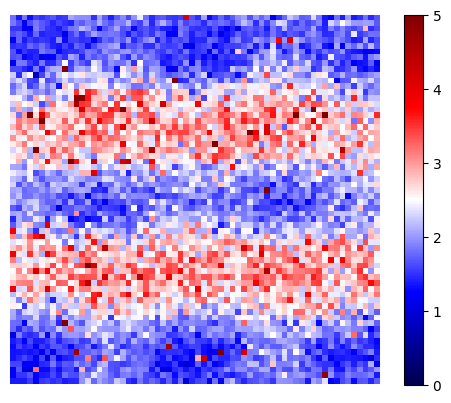

In [28]:
plt.imshow(ratemaps_mean, extent=[-1, 1, -1, 1], origin='lower', cmap='seismic', vmin=0, vmax=5)
plt.axis("off")
plt.colorbar()
plt.show()

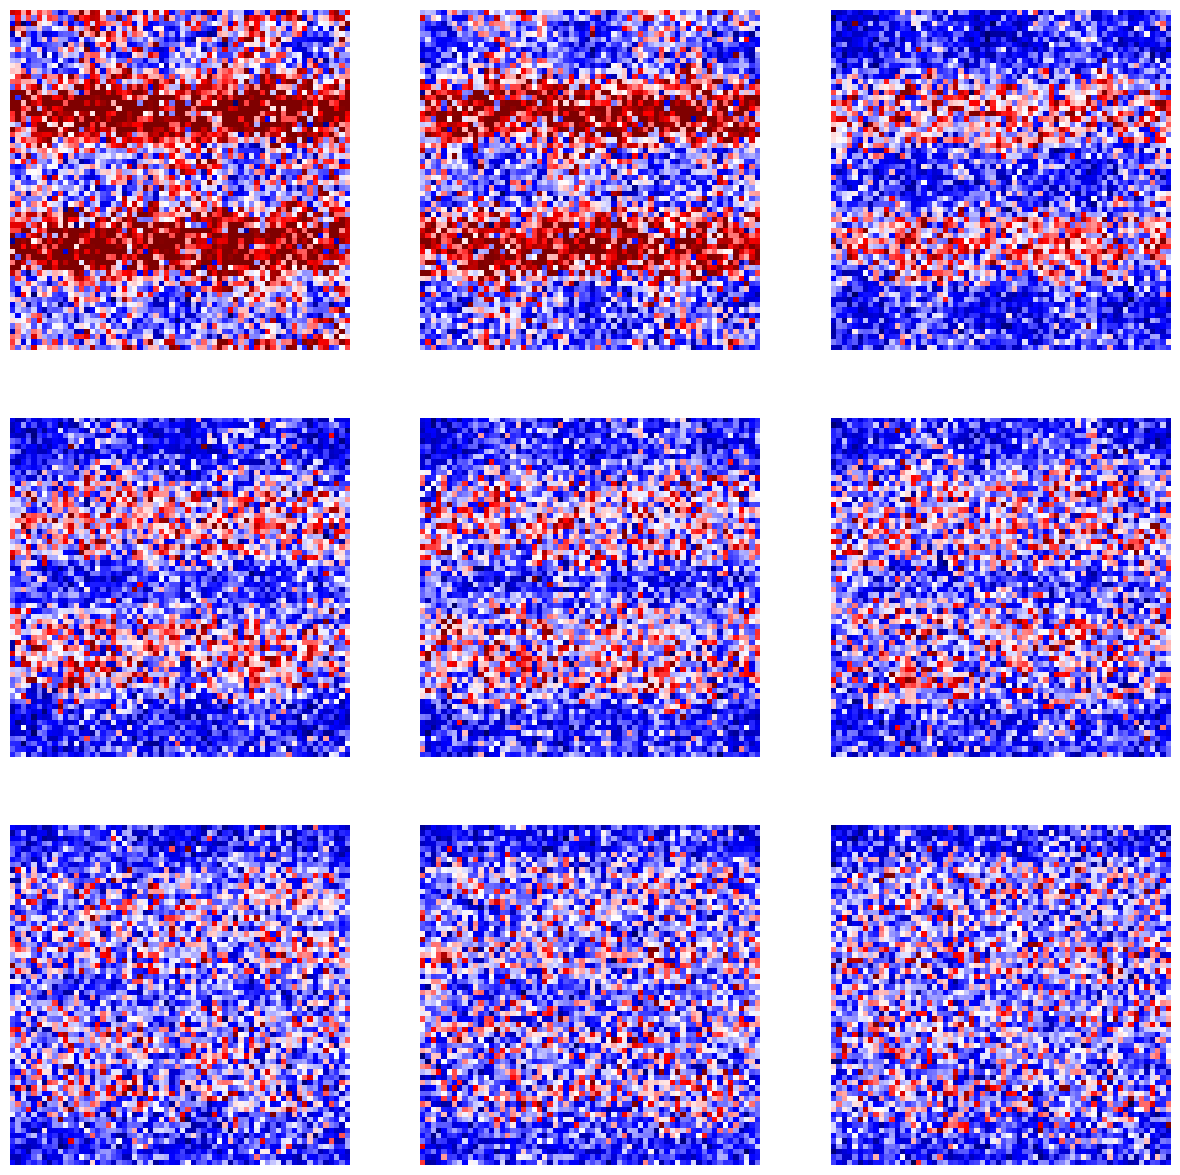

In [27]:
ns = 3 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count], vmin=0, vmax=5, cmap = "seismic")
        ax[i,j].axis("off")
        count += 1